In [ ]:
# import general packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from matplotlib import colormaps

from math import sqrt, pi

from scipy.interpolate import interp1d
from scipy.optimize import brentq, curve_fit
from scipy.ndimage import label, center_of_mass

import h5py
import json
import os
from datetime import datetime

import pde
import phasesep_pyrenoid as ph
from phasesep_pyrenoid.helper_functions import cmap_exp, cmap_orange, dark_orange, colors, colors_exp, colors_phases, add_scalebar, add_timenote
from phasesep_pyrenoid.solvers_simulations import solve_stokes_flow, run_simulation
from droplets import DiffuseDroplet, Emulsion, SphericalDroplet



FOLDER_RESULTS = "./simulation_results/Paper/"
FOLDER_FIGURES= FOLDER_RESULTS+"figures_for_paper/"

with open(FOLDER_RESULTS + "definite/charact_scales.json", "r") as f:
    charact_scales = json.load(f)
T_char, L_char, P_char = (charact_scales[k] for k in ("T_char", "L_char", "P_char"))

In [3]:
def droplet_radius_center(matrix):
    # Step 1: Label connected components
    labeled, num_features = label(matrix)

    # Step 2: Get the center of the matrix
    center = np.array(matrix.shape) / 2

    # Step 3: Compute the center of mass of each droplet
    droplet_centers = center_of_mass(matrix, labeled, range(1, num_features + 1))

    # Step 4: Find the droplet closest to the matrix center
    distances = [np.linalg.norm(np.array(c) - center) for c in droplet_centers]
    if len(distances) == 0:
        return 0
    else:
        closest_index = np.argmin(distances)
        central_label = closest_index + 1  # label values start from 1

        # Step 5: Calculate area (number of pixels)
        area = np.sum(labeled == central_label)

        # Step 6: Equivalent radius
        radius = sqrt(area / pi)

        return radius

# Define the exponential function
def exp_func(x, b, R0):
    return R0 * np.exp(-b * x)

This code plots the exponential decays of radii for different values of kU and kM

## kU = 0

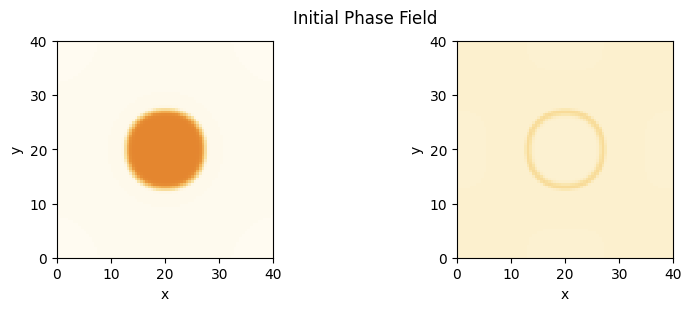

100%|██████████| 200.0/200.0 [02:29<00:00,  1.34it/s]    
100%|██████████| 201/201 [00:10<00:00, 18.69it/s]


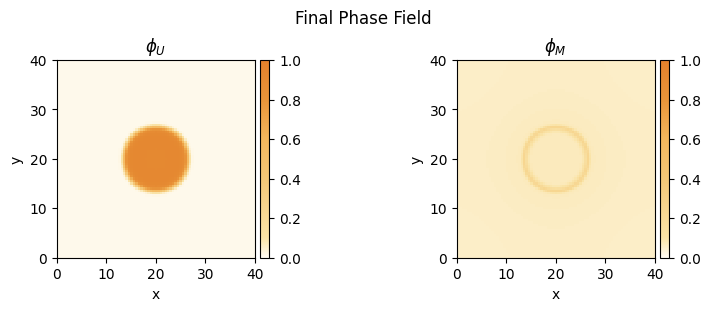

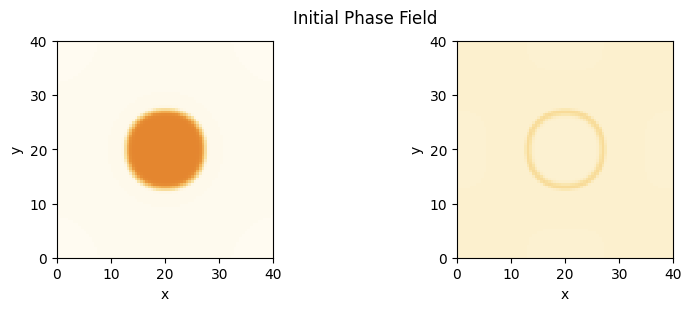

100%|██████████| 200.0/200.0 [02:07<00:00,  1.57it/s]    
100%|██████████| 201/201 [00:10<00:00, 18.32it/s]


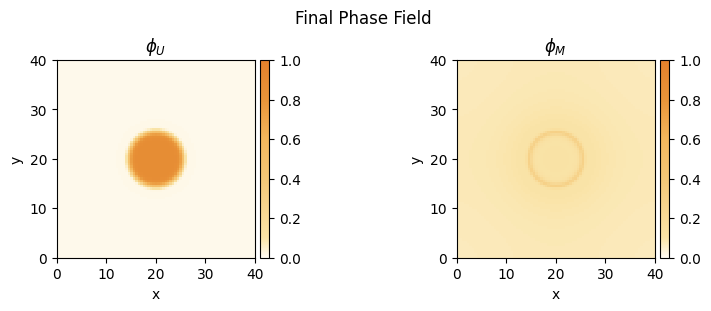

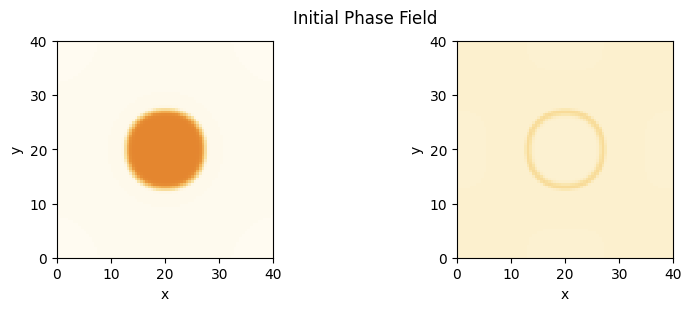

100%|██████████| 200.0/200.0 [01:54<00:00,  1.75it/s]    
100%|██████████| 201/201 [00:10<00:00, 18.64it/s]


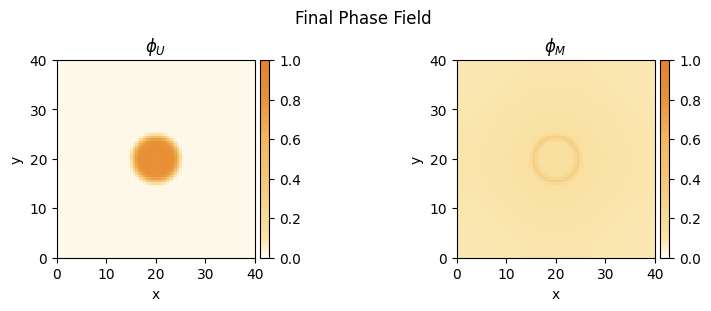

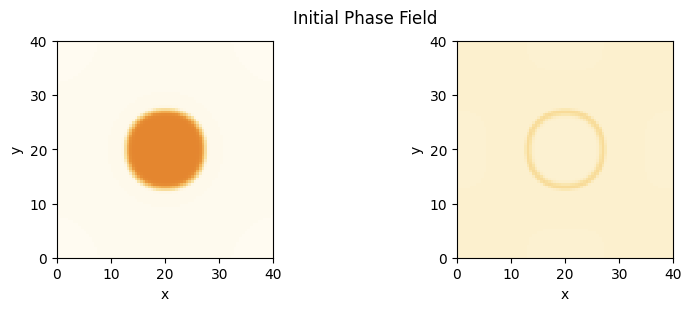

100%|██████████| 200.0/200.0 [01:46<00:00,  1.89it/s]    
100%|██████████| 201/201 [00:11<00:00, 17.67it/s]


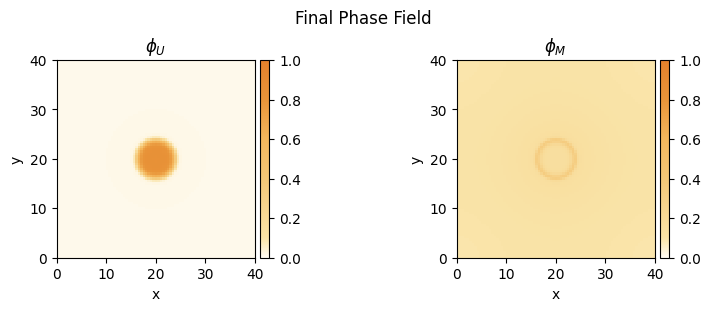

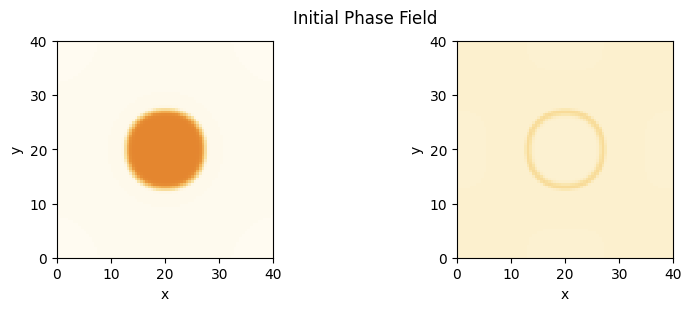

100%|██████████| 200.0/200.0 [01:38<00:00,  2.03it/s]    
100%|██████████| 201/201 [00:11<00:00, 18.27it/s]


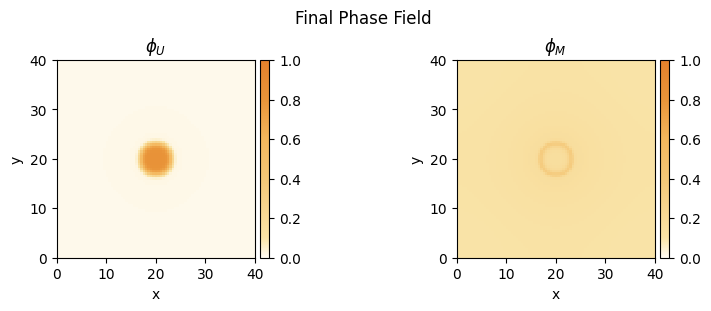

In [29]:
krates = np.linspace(0.001,0.009,5)# Takes smaller rates so exp decay works better as we assume we are in quasi-static approximation

for k_rate in krates:
    chem_react = True
    params_advection = {
            "nx": 83, # Grid size x
            "ny": 83, # Grid size y
            "Lx":40.0, # Domain size x
            "Ly":40.0, # Domain size y
            "mu": 40, # Dynamic viscosity
            "eta": 12.5, # Damping
            "P0": 10, # Max of gaussian pressure
            "sigma_P" : 1.2, # Width of gaussian pressure
        }
    params = {
        "k_M": k_rate if chem_react else 0,
        "k_U": 0 if chem_react else 0,
        "chem_react_type": "ext_maint" if chem_react else "None",
        "xc" : 0.5,
        "b" : 200,
        "d" : 1, #9.6 
        "kappa": 1,
        "chi" : 5, # Positive = repulsion
        "shape" : 40,
        "size" : 81,
        "simulation_time" : 200,
        "periodic_bc" : False,
        "interval_for_tracking" : 1,
        "advection": False
    }

    start_from_input_file = True  #2025-03-07_16-28-16
    input_folder = "simulation_results/Paper/definite/2025-09-22_11-32-48/" if start_from_input_file else None
    input_filename = input_folder+"final_config" if start_from_input_file else None #"asym_eq_config_no_chem_react" #f"phase2_asym__chem_react_kM_0.05_kU_0.05_simT_30"#"eq_config_no_chem_react"#f"Upot3_chem_react_kM_0.05_kU_0.05_simT_100"#"eq_config_no_chem_react"#f"Upot_chem_react_kM_0.05_kU_0.05_simT_{simulation_time}"#"eq_config_no_chem_react" #"phase_1_off_chem_react_kM_0.05_kU_0.05_simT_150" #"eq_config_no_chem_react" 

    # Choose initial conditions for U and M
    selected_init_cond_U = "from_file" if start_from_input_file else "single_droplet"  # Change this to "random" or "emulsion" or "single_droplet" or "start_from_input_file"
    selected_init_cond_M = "from_file" if start_from_input_file else "random"  # Can be different from U

    # Define parameters separately for U and M
    PARAMS_INIT_U = {
        "from_file":{ "filename": input_filename,
            "suffix": "_U.hdf5"
        },
        "random": {
            "phi": 0.3,
            "std": 2e-4
        },
        "single_droplet": {
            "phi_out": 0.0001,
            "phi_in": 0.8,
            "radius": 8,
            "position": [22, 20]  # Relative to shape center
        },
        "emulsion": {
            "phi": 0.5,
            "droplets": [
                {"position": [1/3, 1/3], "radius": 8},
                {"position": [1/3 + 8.2, 1/3 + 8.2], "radius": 3}
            ]
        }
    }

    PARAMS_INIT_M = {
            "from_file":{ "filename": input_filename,
            "suffix": "_M.hdf5",
        },
        "random": {
            "phi": 0.1,
            "std": 2e-4
        },
        "single_droplet": {
            "phi_out": 0.0001,
            "phi_in": 0.8,
            "radius": 8,
            "position": [22, 20]  # Relative to shape center
        },
        "emulsion": {
            "phi_out": 0.0001,
            "phi_in": 0.8,
            "droplets": [
                {"position": [1/3, 1/3], "radius": 7.5},
                {"position": [1/3 + 8.2, 1/3 + 8.2], "radius": 2.5}
            ]
        }
    }

    save_final_config = True
    ### Save params ###
    if save_final_config:
        run_name = f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
        output_folder = f"simulation_results/Paper/definite/radius_shrink_kU0/{run_name}/"
        os.makedirs(output_folder, exist_ok=True)

        with open(f"{output_folder}/params.json", "w") as f:
            json.dump(params, f, indent=4)
        if params["advection"]:
            with open(f"{output_folder}/params_advection.json", "w") as f:
                json.dump(params_advection, f, indent=4)
    output_filename = output_folder+f"final_config"


    P, u, x, y, X, Y = solve_stokes_flow(**params_advection)

    sol, solver_info = run_simulation(selected_init_cond_U,
        selected_init_cond_M,
        PARAMS_INIT_U[selected_init_cond_U],
        PARAMS_INIT_M[selected_init_cond_M],
        save_final_config, input_filename, output_filename, output_folder, chem_react, u = u, cmapcolor = cmap_orange, **params)


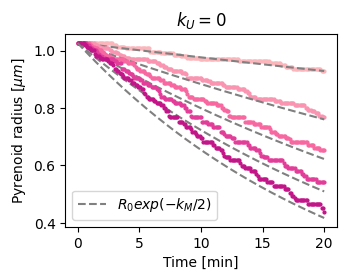

In [21]:
plt.figure(figsize=(3.5,2.5))

parent_folder = "./simulation_results/Paper/definite/radius_shrink_kU0"
all_data = []
i=0
for name in os.listdir(parent_folder):
    storage_read_folder = os.path.join(parent_folder, name)
    storage_read = pde.FileStorage(storage_read_folder+"/final_config.hdf")
    with open(storage_read_folder+'/params.json') as f:
        params = json.load(f)

    n = len(krates)
    cmap = colormaps["RdPu"].resampled(n+6)  # add buffer so darkest isn't too dark
    dx = params["shape"]/params["size"]
    km = params["k_M"]

    droplet_radii = []
    times = []

    for time, UM_fields in storage_read.items():    
            UMdata_binary = UM_fields.data[0]>0.5
            droplet_rad = droplet_radius_center(UMdata_binary)
            droplet_radii.append(droplet_rad)
            times.append(time)

    # Fit the function to the data
    x = np.array(times)
    all_data.append({
        "km": km,
        "times": times,
        "radii": np.array(droplet_radii),
    })

# Step 2: Sort the data by km
all_data_sorted = sorted(all_data, key=lambda d: d["km"])

# Step 3: Plot in sorted order
for i, data in enumerate(all_data_sorted):
    times = data["times"]
    radii = data["radii"]
    km = data["km"]

    plt.plot(x*T_char, radii * L_char*dx, "o", markersize=2,
             color=cmap(i+3)) #label=f"km = {km}", 
    if i == 0:
        plt.plot(x*T_char, exp_func(x, km/2, radii[0])* L_char*dx, color='gray', linestyle =  "--", label = r"$R_0 exp(-k_M/2)$")#, label=f"b = {b_fitR}")
    else:
        plt.plot(x*T_char, exp_func(x, km/2, radii[0])* L_char*dx, color='gray', linestyle =  "--")#, label=f"b = {b_fitR}")
    plt.xlabel("Time [min]")
    plt.ylabel(r"Pyrenoid radius [$\mu m$]")
    i+=1

    plt.legend()
plt.title(r"$k_U = 0$")
plt.savefig(FOLDER_FIGURES+"drops_shrink_ku0.svg", bbox_inches = "tight")
plt.show()



## kU = kM

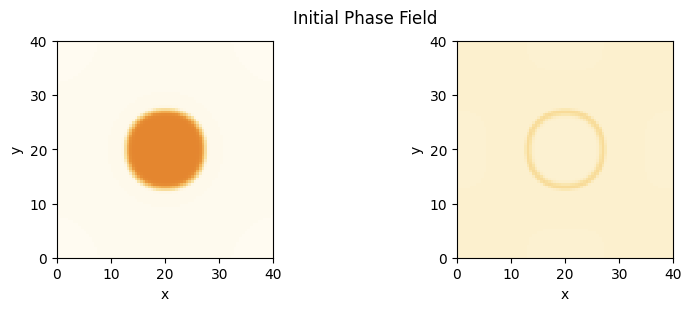

100%|██████████| 100.0/100.0 [01:14<00:00,  1.35it/s]    
100%|██████████| 101/101 [00:05<00:00, 17.66it/s]


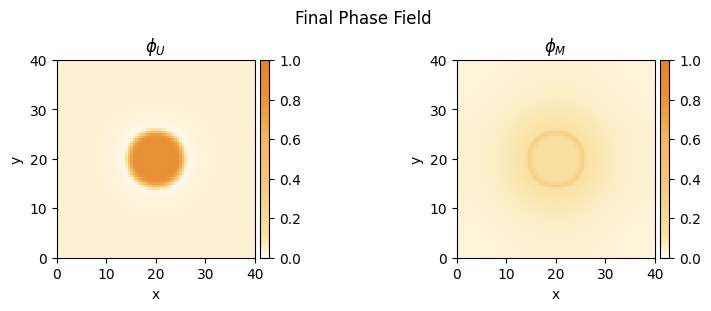

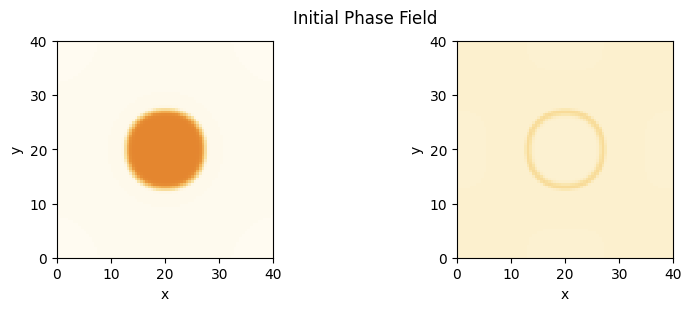

100%|██████████| 100.0/100.0 [01:05<00:00,  1.52it/s]    
100%|██████████| 101/101 [00:05<00:00, 17.64it/s]


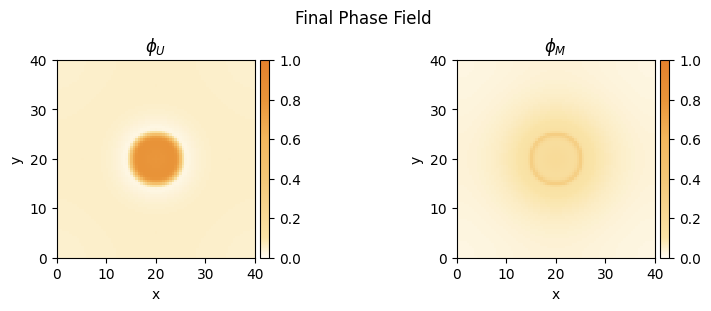

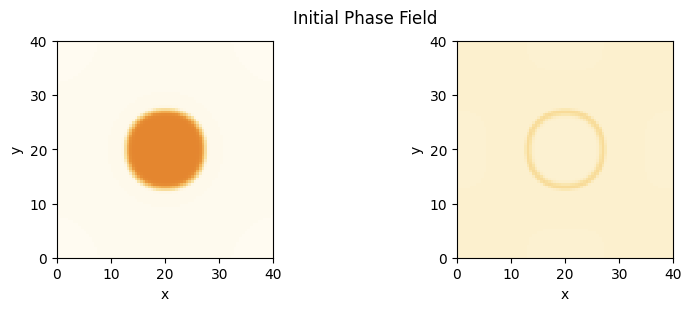

100%|██████████| 100.0/100.0 [00:57<00:00,  1.73it/s]    
100%|██████████| 101/101 [00:05<00:00, 18.05it/s]


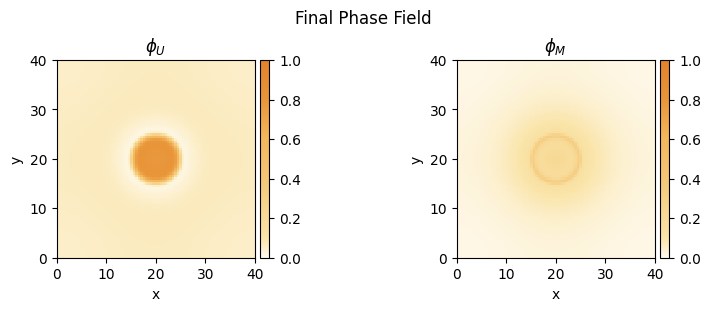

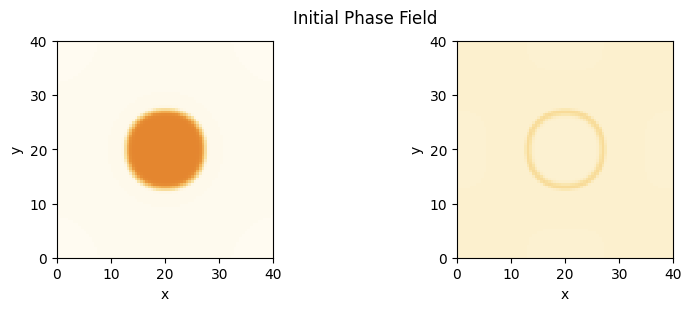

100%|██████████| 100.0/100.0 [00:53<00:00,  1.87it/s]    
100%|██████████| 101/101 [00:05<00:00, 17.17it/s]


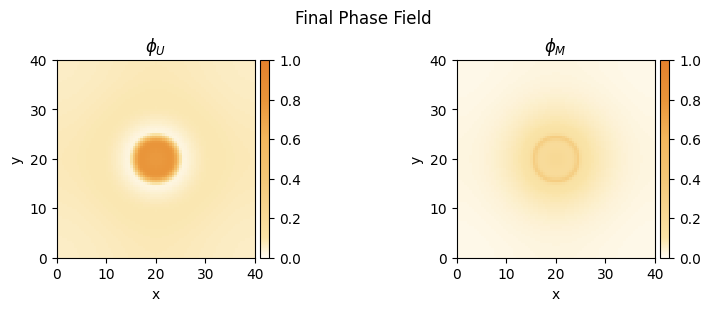

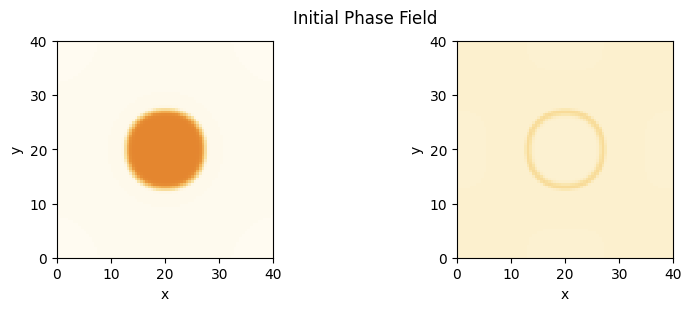

100%|██████████| 100.0/100.0 [00:51<00:00,  1.94it/s]    
100%|██████████| 101/101 [00:05<00:00, 17.58it/s]


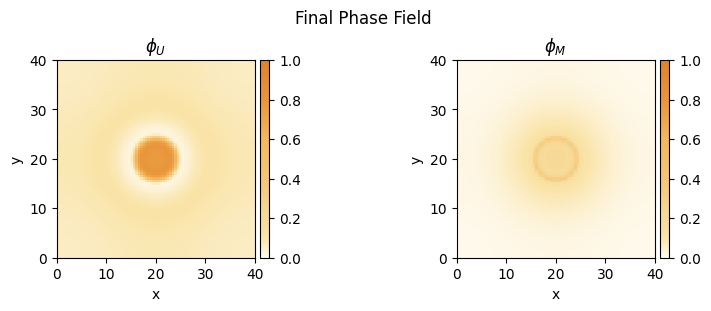

In [6]:
krates = np.linspace(0.01,0.03,5)# Takes smaller rates so exp decay works better as we assume we are in quasi-static approximation

for k_rate in krates:
    chem_react = True
    params_advection = {
            "nx": 83, # Grid size x
            "ny": 83, # Grid size y
            "Lx":40.0, # Domain size x
            "Ly":40.0, # Domain size y
            "mu": 40, # Dynamic viscosity
            "eta": 12.5, # Damping
            "P0": 10, # Max of gaussian pressure
            "sigma_P" : 1.2, # Width of gaussian pressure
        }
    params = {
        "k_M": k_rate if chem_react else 0,
        "k_U": k_rate if chem_react else 0,
        "chem_react_type": "ext_maint" if chem_react else "None",
        "xc" : 0.5,
        "b" : 200,
        "d" : 1, #9.6 
        "kappa": 1,
        "chi" : 5, # Positive = repulsion
        "shape" : 40,
        "size" : 81,
        "simulation_time" : 100,
        "periodic_bc" : False,
        "interval_for_tracking" : 1,
        "advection": False
    }

    start_from_input_file = True  #2025-03-07_16-28-16
    input_folder = "simulation_results/Paper/definite/2025-09-22_11-32-48/" if start_from_input_file else None
    input_filename = input_folder+"final_config" if start_from_input_file else None #"asym_eq_config_no_chem_react" #f"phase2_asym__chem_react_kM_0.05_kU_0.05_simT_30"#"eq_config_no_chem_react"#f"Upot3_chem_react_kM_0.05_kU_0.05_simT_100"#"eq_config_no_chem_react"#f"Upot_chem_react_kM_0.05_kU_0.05_simT_{simulation_time}"#"eq_config_no_chem_react" #"phase_1_off_chem_react_kM_0.05_kU_0.05_simT_150" #"eq_config_no_chem_react" 

    # Choose initial conditions for U and M
    selected_init_cond_U = "from_file" if start_from_input_file else "single_droplet"  # Change this to "random" or "emulsion" or "single_droplet" or "start_from_input_file"
    selected_init_cond_M = "from_file" if start_from_input_file else "random"  # Can be different from U

    # Define parameters separately for U and M
    PARAMS_INIT_U = {
        "from_file":{ "filename": input_filename,
            "suffix": "_U.hdf5"
        },
        "random": {
            "phi": 0.3,
            "std": 2e-4
        },
        "single_droplet": {
            "phi_out": 0.0001,
            "phi_in": 0.8,
            "radius": 8,
            "position": [22, 20]  # Relative to shape center
        },
        "emulsion": {
            "phi": 0.5,
            "droplets": [
                {"position": [1/3, 1/3], "radius": 8},
                {"position": [1/3 + 8.2, 1/3 + 8.2], "radius": 3}
            ]
        }
    }

    PARAMS_INIT_M = {
            "from_file":{ "filename": input_filename,
            "suffix": "_M.hdf5",
        },
        "random": {
            "phi": 0.1,
            "std": 2e-4
        },
        "single_droplet": {
            "phi_out": 0.0001,
            "phi_in": 0.8,
            "radius": 8,
            "position": [22, 20]  # Relative to shape center
        },
        "emulsion": {
            "phi_out": 0.0001,
            "phi_in": 0.8,
            "droplets": [
                {"position": [1/3, 1/3], "radius": 7.5},
                {"position": [1/3 + 8.2, 1/3 + 8.2], "radius": 2.5}
            ]
        }
    }

    save_final_config = True
    ### Save params ###
    if save_final_config:
        run_name = f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
        output_folder = f"simulation_results/Paper/definite/radius_shrink_same_rates/{run_name}/"
        os.makedirs(output_folder, exist_ok=True)

        with open(f"{output_folder}/params.json", "w") as f:
            json.dump(params, f, indent=4)
        if params["advection"]:
            with open(f"{output_folder}/params_advection.json", "w") as f:
                json.dump(params_advection, f, indent=4)
    output_filename = output_folder+f"final_config"


    P, u, x, y, X, Y = solve_stokes_flow(**params_advection)

    sol, solver_info = run_simulation(selected_init_cond_U,
        selected_init_cond_M,
        PARAMS_INIT_U[selected_init_cond_U],
        PARAMS_INIT_M[selected_init_cond_M],
        save_final_config, input_filename, output_filename, output_folder, chem_react, u = u, cmapcolor = cmap_orange, **params)


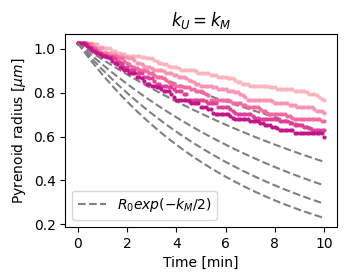

In [24]:
plt.figure(figsize=(3.5,2.5))

parent_folder = "./simulation_results/Paper/definite/radius_shrink_same_rates"
all_data = []
i=0
for name in os.listdir(parent_folder):
    storage_read_folder = os.path.join(parent_folder, name)
    storage_read = pde.FileStorage(storage_read_folder+"/final_config.hdf")
    with open(storage_read_folder+'/params.json') as f:
        params = json.load(f)

    n = len(krates)
    cmap = colormaps["RdPu"].resampled(n+6)  # add buffer so darkest isn't too dark
    dx = params["shape"]/params["size"]
    km = params["k_M"]

    droplet_radii = []
    times = []

    for time, UM_fields in storage_read.items():    
            UMdata_binary = UM_fields.data[0]>0.5
            droplet_rad = droplet_radius_center(UMdata_binary)
            droplet_radii.append(droplet_rad)
            times.append(time)

    # Fit the function to the data
    x = np.array(times)
    all_data.append({
        "km": km,
        "times": times,
        "radii": np.array(droplet_radii),
    })

# Step 2: Sort the data by km
all_data_sorted = sorted(all_data, key=lambda d: d["km"])

# Step 3: Plot in sorted order
for i, data in enumerate(all_data_sorted):
    times = data["times"]
    radii = data["radii"]
    km = data["km"]

    plt.plot(x*T_char, radii * L_char*dx, "o", markersize=2,
             color=cmap(i+3)) #label=f"km = {km}", 
    if i == 0:
        plt.plot(x*T_char, exp_func(x, km/2, radii[0])* L_char*dx, color='gray', linestyle =  "--", label = r"$R_0 exp(-k_M/2)$")#, label=f"b = {b_fitR}")
    else:
        plt.plot(x*T_char, exp_func(x, km/2, radii[0])* L_char*dx, color='gray', linestyle =  "--")#, label=f"b = {b_fitR}")
    plt.xlabel("Time [min]")
    plt.ylabel(r"Pyrenoid radius [$\mu m$]")
    i+=1

    plt.legend(loc = "lower left")
plt.title(r"$k_U = k_M$")
plt.savefig(FOLDER_FIGURES+"drops_shrink_ku_km_equal.svg", bbox_inches = "tight")

